# MultiClass Classification


## Definition of `NeuralNetworkClassifier`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys

import torch
import mlutilities as ml  
import optimizers as opt 

import neuralnetworks as nn



class NeuralNetworkClassifier(nn.NeuralNetwork):

    # Constructor
    def __init__(self, n_inputs, n_hiddens_list, classes, use_torch=False):


        
        if not isinstance(n_hiddens_list, list):
            raise Exception('NeuralNetworkClassifier: n_hiddens_list must be a list.')
 

        
        super().__init__(n_inputs, n_hiddens_list, len(classes), use_torch)


        
        self.classes = np.array(classes) 
        
        if use_torch:
            self.log = torch.log
            self.exp = torch.exp
        else:
            self.log = np.log
            self.exp = np.exp
        

# Rest of the Class Methods

    def __repr__(self):
        str = f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_list}, {self.classes}, use_torch={self.use_torch})'
        if self.trained:
            str += f'\n   Network was trained for {self.n_epochs} epochs'
            str += f' that took {self.training_time:.4f} seconds. Final objective value is {self.error_trace[-1]:.3f}'
        else:
            str += '  Network is not trained.'
        return str

    def _standardizeT(self, T):
        return T

    def _unstandardizeT(self, Ts):
        return Ts

    def _forward_pass(self, X):
       
        Z_prev = X  
        Z = [Z_prev]
        for i in range(self.n_hidden_layers):
            V = self.Vs[i]
            Z_prev = self.tanh(Z_prev @ V[1:, :] + V[0:1, :])
            Z.append(Z_prev)
        Y = np.exp(Z_prev @ self.W[1:, :] + self.W[0:1, :])
        Y = Y/np.sum(Y,axis = 1).reshape(-1, 1)
        return Y, Z

    def _objective_to_actual(self, neg_mean_log_likelihood):
        return self.exp(- neg_mean_log_likelihood)

    def _objectiveF(self, w, X, T):
        self._unpack(w)
        Y, _ = self._forward_pass(X)
        return -np.mean(T * (np.log(Y)))

    def train(self, X, T, n_epochs, method='scg',
        verbose=False, save_weights_history=False,
        learning_rate=0.001, momentum_rate=0.0): 

        if X.shape[1] != self.n_inputs:
            raise Exception(f'train: number of columns in X ({X.shape[1]}) not equal to number of network inputs ({self.n_inputs})')
        
        if self.use_torch:
            X = torch.tensor(X, dtype=torch.float)  
            T = torch.tensor(T, dtype=torch.float)

        self._setup_standardize(X, T)
        X = self._standardizeX(X)
        T = self._standardizeT(T)
        T_ind = makeIndicatorVars(T)
        
        try:
            algo = [opt.sgd, opt.adam, opt.scg][['sgd', 'adam', 'scg'].index(method)]
        except:
            raise Exception("train: method={method} not one of 'scg', 'sgd' or 'adam'")            

        result = algo(self._pack(self.Vs, self.W),
                      self._objectiveF,
                      [X, T_ind], n_epochs,
                      self._gradientF,  
                      eval_f=self._objective_to_actual,
                      learning_rate=learning_rate, momentum_rate=momentum_rate,
                      verbose=verbose, use_torch=self.use_torch,
                      save_wtrace=save_weights_history)

        self._unpack(result['w'])
        self.reason = result['reason']
        self.error_trace = result['ftrace'] 
        self.n_epochs = len(self.error_trace) - 1
        self.trained = True
        self.weight_history = result['wtrace'] if save_weights_history else None
        self.training_time = result['time']
        return self

    def use(self, X, all_outputs=False):
        if self.use_torch:
            if not isinstance(X, torch.Tensor):
                X = torch.tensor(X, dtype=torch.float)
        X = self._standardizeX(X)
        Y, Z = self._forward_pass(X)
        Y = self._unstandardizeT(Y)
        if self.use_torch:
            Y = Y.detach().cpu().numpy()
            Z = [Zi.detach().cpu().numpy() for Zi in Z]
        

        Y_classes = np.argmax(Y, axis= 1)

        return  (Y_classes.reshape(len(Y_classes),1), Y, Z[1:]) if all_outputs else (Y_classes.reshape(len(Y_classes),1), Y)


In [2]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
%matplotlib inline

import neuralnetworks as nn

In [3]:
#def makeIndicatorVars(T):
 #   if nnet_new.use_torch:
  #      if not isinstance(T, torch.Tensor):
   #         T= torch.Tensor(T, dtype=torch.int)
    #    if T.dim() == 1:
     #       T = T.reshape((-1,1))    
      #      return (T == torch.unique(T)).astype(int)
   # else:
    #    if T.ndim == 1:
     #       T= T.reshape((-1,1))
      #      return (T == np.unique(T)).astype(int)

In [4]:
def makeIndicatorVars(T):
    # Make sure T is two-dimensiona. Should be nSamples x 1.
    if T.ndim == 1:
        T = T.reshape((-1,1))    
    return (T == np.unique(T)).astype(int)

## Getting Data
Crowdsourced Mapping Data Set: This dataset was derived from geospatial data

In [5]:
!unzip -o Crowdsourced_Mapping.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
data = pandas.read_csv('training.csv', usecols=range(20))
data= data[:1000]
data

,class,max_ndvi,20150720_N,20150602_N,20150517_N,20150501_N,20150415_N,20150330_N,20150314_N,20150226_N,20150210_N,20150125_N,20150109_N,20141117_N,20141101_N,20141016_N,20140930_N,20140813_N,20140626_N,20140610_N
0,water,997.904,637.5950,658.668,-1882.030,-1924.360,997.904,-1739.990,630.087,-1628.240,-1325.640,-944.084,277.107,-206.7990,536.441,749.348,-482.993,492.001,655.770,-921.193
1,water,914.198,634.2400,593.705,-1625.790,-1672.320,914.198,-692.386,707.626,-1670.590,-1408.640,-989.285,214.200,-75.5979,893.439,401.281,-389.933,394.053,666.603,-954.719
2,water,3800.810,1671.3400,1206.880,449.735,1071.210,546.371,1077.840,214.564,849.599,1283.630,1304.910,542.100,922.6190,889.774,836.292,1824.160,1670.270,2307.220,1562.210
3,water,952.178,58.0174,-1599.160,210.714,-1052.630,578.807,-1564.630,-858.390,729.790,-3162.140,-1521.680,433.396,228.1530,555.359,530.936,952.178,-1074.760,545.761,-1025.880
4,water,1232.120,72.5180,-1220.880,380.436,-1256.930,515.805,-1413.180,-802.942,683.254,-2829.400,-1267.540,461.025,317.5210,404.898,563.716,1232.120,-117.779,682.559,-1813.950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,forest,7965.760,7681.5900,7543.060,7352.210,1806.650,6859.310,7179.220,5822.240,7479.300,2115.240,7383.520,6269.440,7965.7600,1322.800,1670.640,5762.830,893.801,1598.880,7429.850
996,forest,8135.500,1596.3700,7277.900,7064.540,683.266,6627.010,6980.600,6836.820,7523.240,737.011,7750.380,7292.960,8135.5000,6717.920,2052.660,5125.960,971.687,2196.420,7354.460
997,forest,8479.180,4790.8500,6658.670,995.759,1301.530,5939.400,4439.020,2896.280,7334.300,6219.970,8009.160,3378.040,8479.1800,4869.610,2225.840,5310.140,1049.040,1009.080,7782.430
998,forest,8276.310,7635.7500,738.876,6792.230,5922.600,5455.430,6021.450,6230.290,7189.600,6957.230,7900.960,5585.850,8276.3100,682.833,3303.130,1982.550,970.448,998.773,4606.420


In [7]:
data2 = data[['max_ndvi', '20150720_N', '20150602_N', '20150517_N', '20150501_N', '20150415_N', '20150330_N', '20150314_N']]
data2
x1 = np.array([float(t) for t in data2['max_ndvi']])
x2 = np.array([float(t) for t in data2['20150720_N']])
x3 = np.array([float(t) for t in data2['20150602_N']])
x4 = np.array([float(t) for t in data2['20150517_N']])
x5 = np.array([float(t) for t in data2['20150501_N']])
x6 = np.array([float(t) for t in data2['20150415_N']])
x7 = np.array([float(t) for t in data2['20150330_N']])
x8 = np.array([float(t) for t in data2['20150314_N']])
X1 = (x1 ,x2, x3 , x4, x5, x6, x7, x8)
X1 = np.array(X1)
X=X1.T.reshape((-1,1))
X=X.reshape(1000,8)

In [8]:
Class = np.array(data['class'])
T=[0]*len(Class)


In [9]:
for i in range(len(Class)):
    if Class[i]== 'water':
        T[i]= 0
    elif Class[i] == 'forest':
        T[i]= 1
    elif Class[i] == 'impervious':
        T[i]= 2
    elif Class[i] == 'farm':
        T[i]= 3
    elif Class[i] == 'grass':
        T[i]= 4
    elif Class[i] == 'orchad':
        T[i]= 5
T = np.array(T).reshape((-1,1))


In [10]:
X.shape,T.shape

((1000, 8), (1000, 1))

In [11]:
T=T.astype(float)

## Testing The Data

In [12]:
nnet_new = NeuralNetworkClassifier(8, [25, 25], [0, 1])
nnet_new

NeuralNetworkClassifier(8, [25, 25], [0 1], use_torch=False)  Network is not trained.

In [13]:
nnet_new.train(X, T, 100)

NeuralNetworkClassifier(8, [25, 25], [0 1], use_torch=False)
   Network was trained for 100 epochs that took 0.6167 seconds. Final objective value is 0.993

In [14]:
Y_classes, Y = nnet_new.use(X)
Y_classes.shape, Y.shape

((1000, 1), (1000, 2))

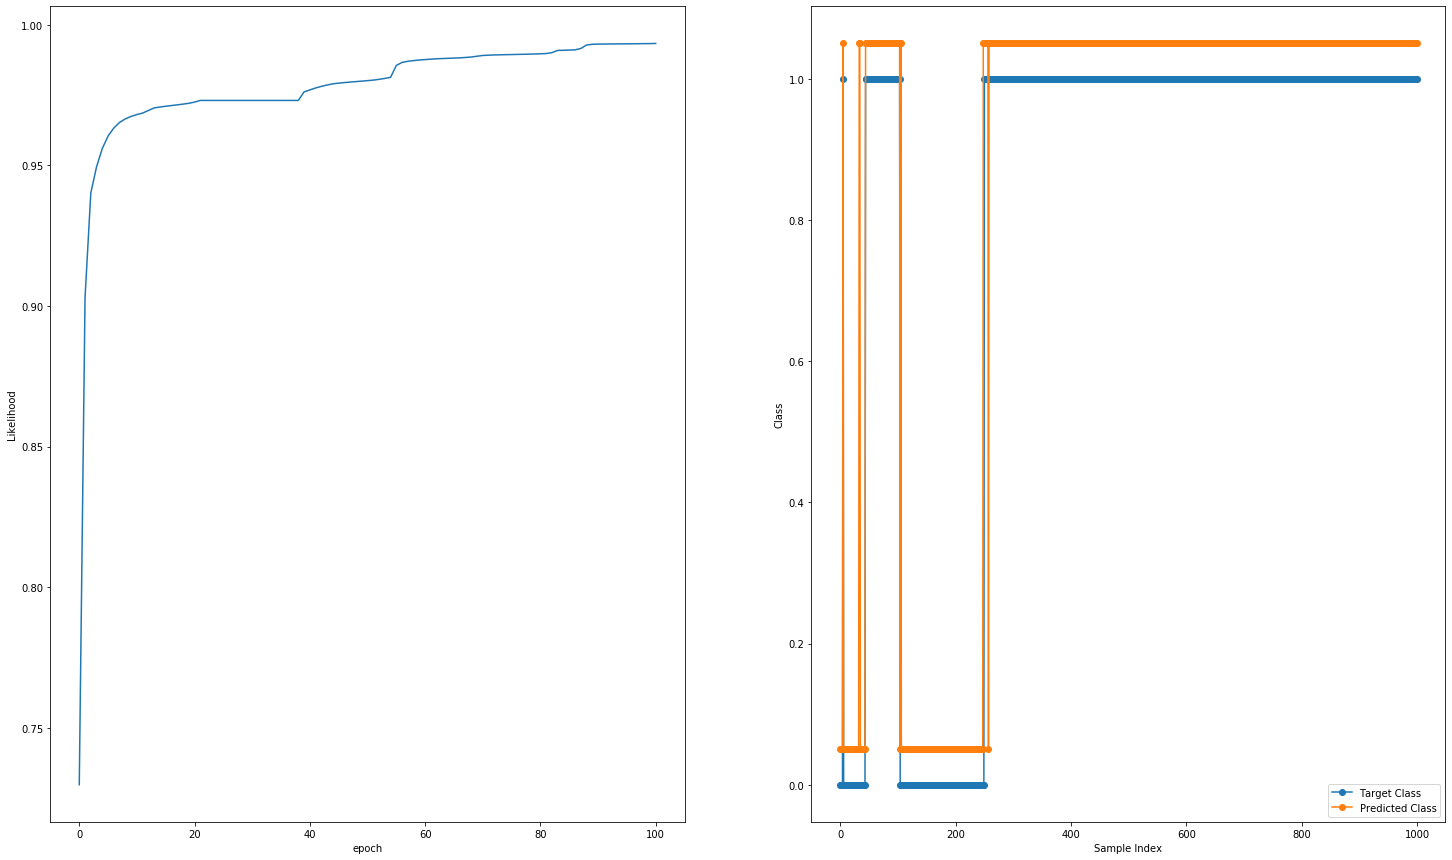

In [15]:
plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plt.plot(nnet_new.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T, 'o-')
plt.plot(Y_classes + 0.05, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

### With Different epochs, different network size and optimization algorithms

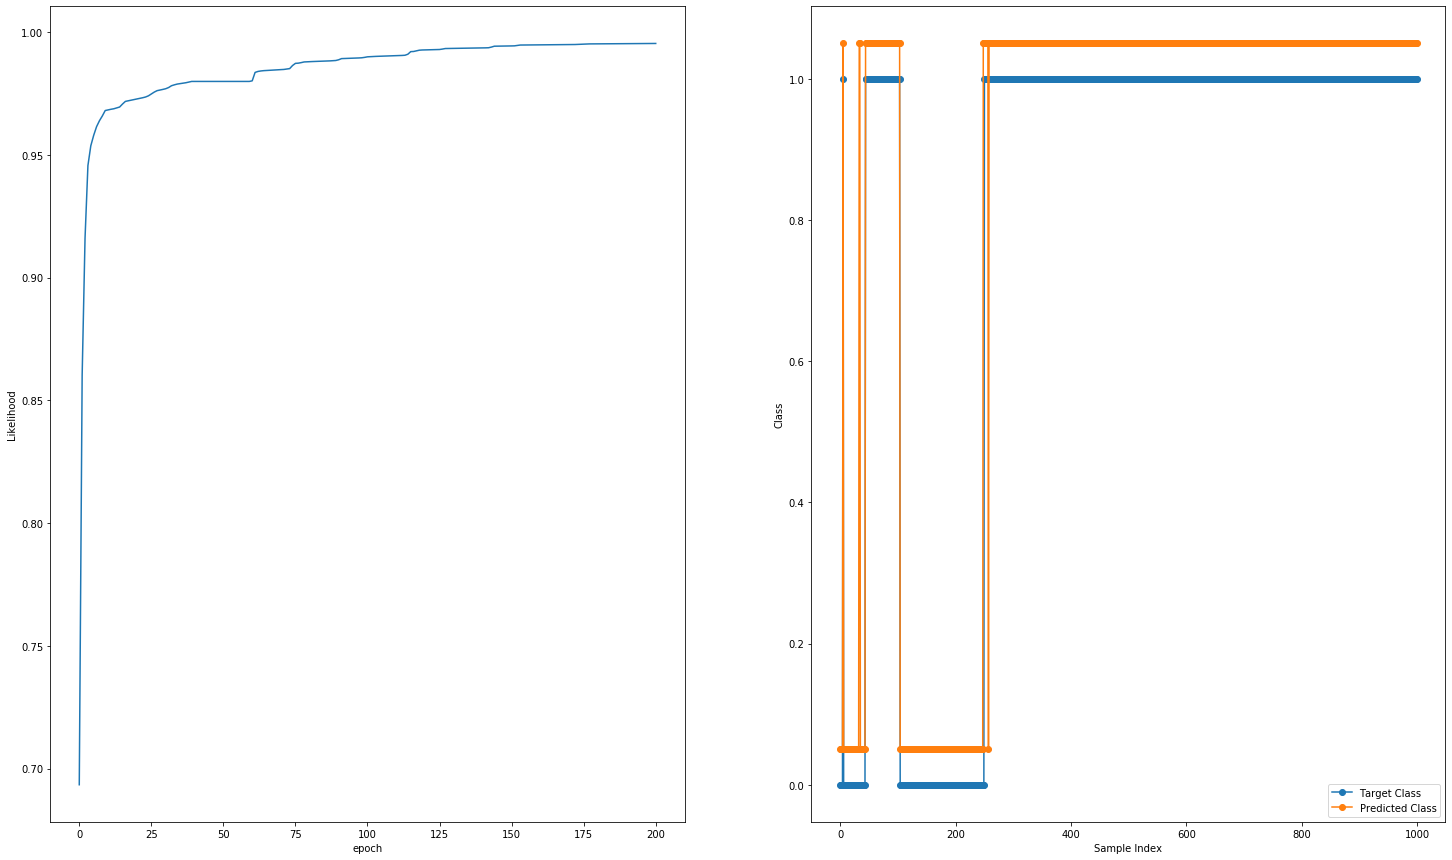

In [16]:
nnet_new = NeuralNetworkClassifier(8, [20, 25], [0, 1])
nnet_new.train(X, T, 200) #200 epochs
Y_classes, Y = nnet_new.use(X)
Y_classes.shape, Y.shape
plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plt.plot(nnet_new.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T, 'o-')
plt.plot(Y_classes + 0.05, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

### SGD 

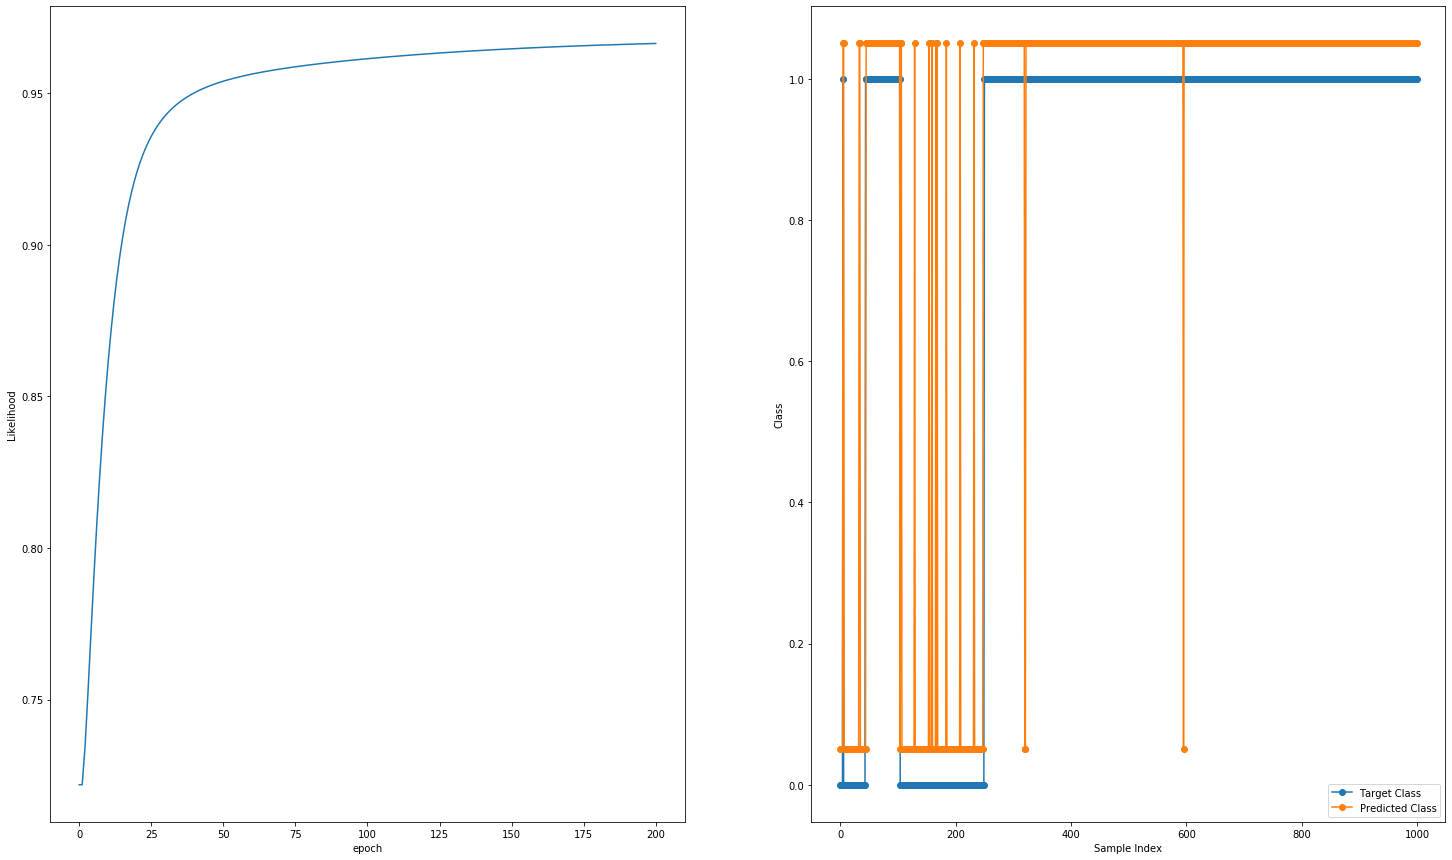

In [17]:
nnet_new = NeuralNetworkClassifier(8, [25, 25], [0, 1])
nnet_new.train(X, T, 200, method='sgd', learning_rate=0.1, momentum_rate=0.5)
Y_classes, Y = nnet_new.use(X)
Y_classes.shape, Y.shape
plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plt.plot(nnet_new.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T, 'o-')
plt.plot(Y_classes + 0.05, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

### SCG

R:\ML\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in exp
R:\ML\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
R:\ML\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log
R:\ML\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in multiply


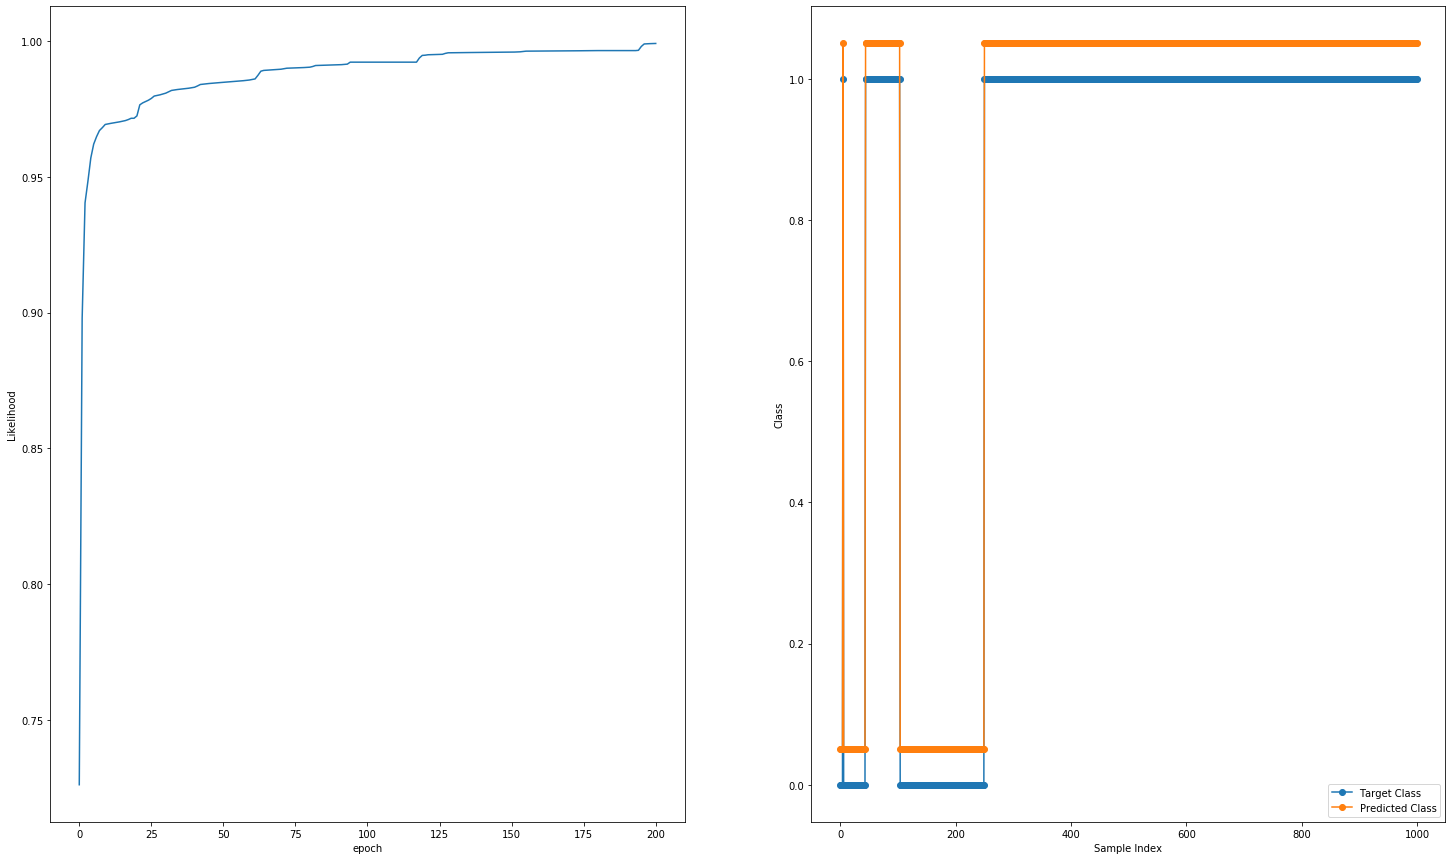

In [18]:
nnet_new = NeuralNetworkClassifier(8, [25, 25], [0, 1])
nnet_new.train(X, T, 200, method='scg')
Y_classes, Y = nnet_new.use(X)
Y_classes.shape, Y.shape
plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plt.plot(nnet_new.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T, 'o-')
plt.plot(Y_classes + 0.05, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

### ADAM

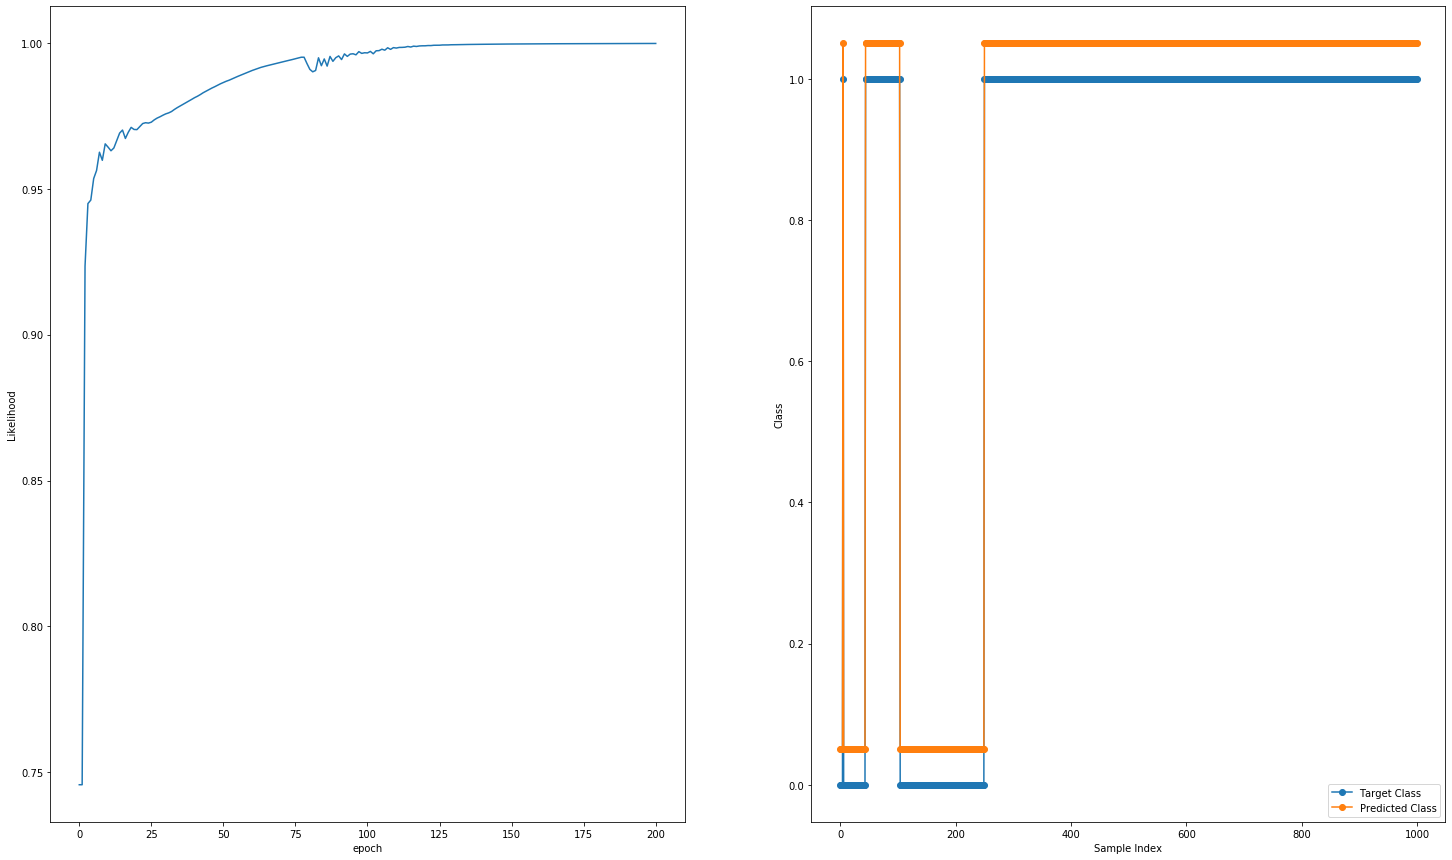

In [19]:
nnet_new = NeuralNetworkClassifier(8, [25, 25], [0, 1])
nnet_new.train(X, T, 200, method='adam', learning_rate=0.1)
Y_classes, Y = nnet_new.use(X)
Y_classes.shape, Y.shape
plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plt.plot(nnet_new.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T, 'o-')
plt.plot(Y_classes + 0.05, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

### Discussion

While working with the data almost more than 2000 samples taken were either water or forest, hence, while working with it we must alter the classifications and number of samples simultaneously and carefully. 

0 in the graphs above means 'water' and 1 is 'forest'; and also I didn't consider all the months of data, rather 6 months of data in the year of 2015. 

Limited to the information, our algorithms still perform quite good. Saying that, we must note SGD does quite poorly compared to SCG and ADAM. 